In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

In [2]:
df = pd.read_csv('tsc.csv')

In [3]:
df.head(3).append(df.tail(3))

,date,transactions
0,2013-01-01,770
1,2013-01-02,93215
2,2013-01-03,78504
1679,2017-08-13,85993
1680,2017-08-14,85448
1681,2017-08-15,86561


## EDA

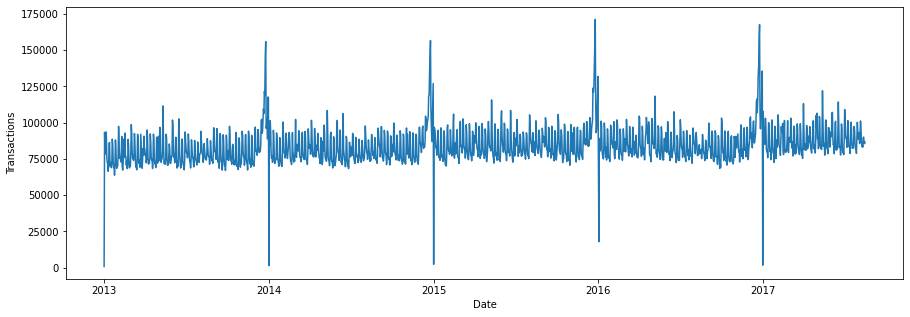

In [4]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df['transactions'])
ax.set_xlabel('Date')
ax.set_ylabel('Transactions')

plt.xticks(np.arange(0, 1681, 364), np.arange(2013, 2018, 1))

plt.show()

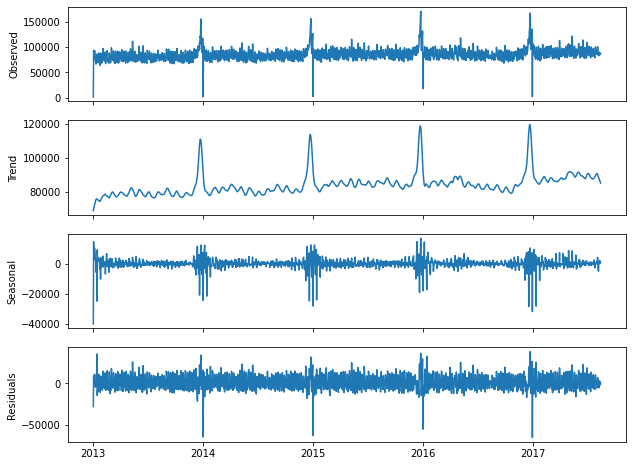

In [5]:
decomposition = STL(df['transactions'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 1684, 364), np.arange(2013, 2018, 1))

plt.show()

In [6]:
ad_fuller_result = adfuller(df['transactions'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.95637531299986
p-value: 2.088545934367482e-07


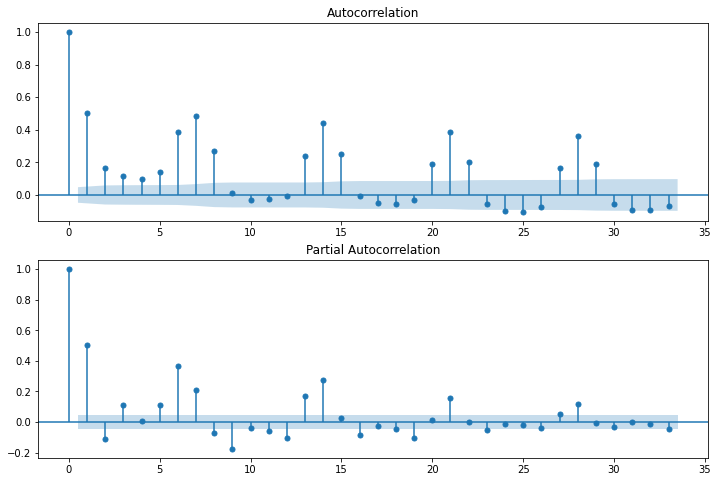

In [7]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['transactions'], ax=ax[0])
plot_pacf(df['transactions'], ax=ax[1])
plt.show()

## Train/Test Split

In [8]:
train = df[:-10]
test = df[-10:]

train.tail()

,date,transactions
1667,2017-08-01,92083
1668,2017-08-02,93023
1669,2017-08-03,85521
1670,2017-08-04,91305
1671,2017-08-05,101108


## SARIMA Model

In [9]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
ps = range(6, 9, 1)
qs = range(0, 4, 1)
Ps = range(6, 9, 1)
Qs = range(0, 4, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
s = 7

In [11]:
import warnings
warnings.filterwarnings('ignore')

SARIMA_result_df = optimize_SARIMA(train['transactions'], order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/144 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(6, 2, 8, 1)",35050.290312
1,"(6, 2, 6, 2)",35050.737336
2,"(6, 3, 6, 1)",35050.747216
3,"(6, 2, 6, 3)",35051.177092
4,"(6, 2, 7, 1)",35051.205160
5,"(6, 2, 7, 2)",35052.077393
6,"(6, 2, 6, 1)",35052.269496
7,"(6, 2, 8, 2)",35053.616705
8,"(6, 2, 8, 0)",35053.832078
9,"(6, 2, 7, 3)",35054.397733


In [13]:
SARIMA_model = SARIMAX(train['transactions'], order=(6,1,2), seasonal_order=(8,0,1,7), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        transactions   No. Observations:                 1672
Model:             SARIMAX(6, 1, 2)x(8, 0, [1], 7)   Log Likelihood              -17507.145
Date:                             Wed, 01 Mar 2023   AIC                          35050.290
Time:                                     19:02:31   BIC                          35147.872
Sample:                                          0   HQIC                         35086.446
                                            - 1672                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0013      0.266     -0.005      0.996      -0.522       0.520
ar.L2          0.1852      

In [14]:
SARIMA_pred = SARIMA_model_fit.get_prediction(1672, 1681).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

test

,date,transactions,SARIMA_pred
1672,2017-08-06,96162,97844.745975
1673,2017-08-07,87072,88082.495133
1674,2017-08-08,83422,86349.985999
1675,2017-08-09,85452,86270.441861
1676,2017-08-10,83064,82379.983009
1677,2017-08-11,89551,89382.266612
1678,2017-08-12,89927,100949.307951
1679,2017-08-13,85993,96923.377285
1680,2017-08-14,85448,86957.817591
1681,2017-08-15,86561,85730.488452


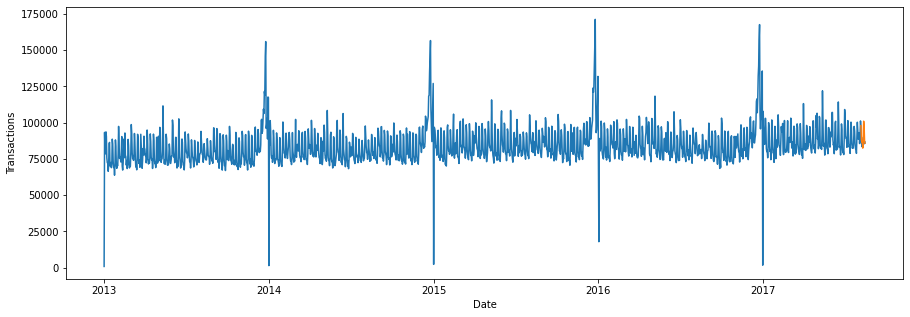

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df['transactions'])
ax.plot(test['SARIMA_pred'])
ax.set_xlabel('Date')
ax.set_ylabel('Transactions')

plt.xticks(np.arange(0, 1684, 364), np.arange(2013, 2018, 1))

plt.show()

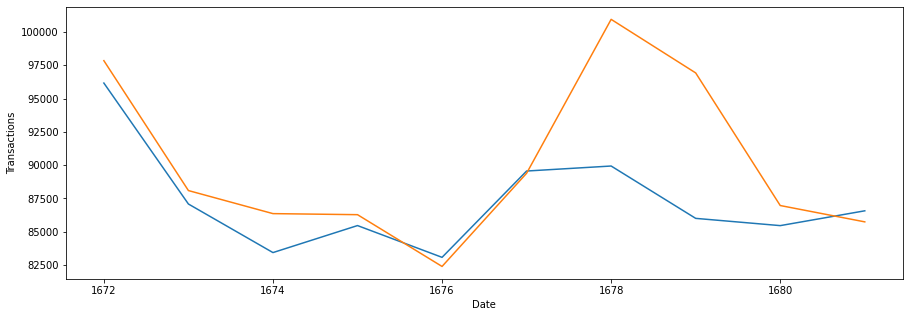

In [16]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(test['transactions'])
ax.plot(test['SARIMA_pred'])
ax.set_xlabel('Date')
ax.set_ylabel('Transactions')

plt.show()

## Forecast Evaluation

In [17]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['transactions'], test['SARIMA_pred'])
print(mae)

3158.543372298888


In [18]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mape_SARIMA = mape(test['transactions'], test['SARIMA_pred'])

print(mape_SARIMA)

3.6084089165989193


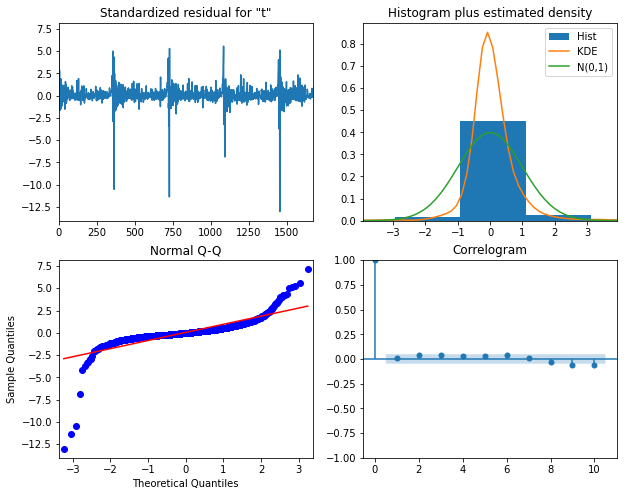

In [20]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));